## This example show the ability of CNN with encoder-decoder architecture to approximate complex media data with periodic component.  

#### As data source gif-file with Menhera manga character was used. Gif-file contains 10 frames (3 channel RGB images). Resolution of images was reduced to 45x45 pixels to light the task.

![SegmentLocal](tools/media/anime_10f_fullsize.gif "segment")

#### Function to prepare dataset from gif-file to numpy matrices  

In [1]:
import numpy as np
from PIL import Image, ImageSequence

def get_anime_timeseries(rgb=True):
    with Image.open('tools/media/anime_10f.gif') as im:
        array = []
        for frame in ImageSequence.Iterator(im):
            if rgb:
                im_data = frame.copy().convert('RGB').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 3)
            else:
                im_data = frame.copy().convert('L').getdata()
                im_array = np.array(im_data).reshape(frame.size[1], frame.size[0], 1)
            array.append(im_array)
        array = np.array(array)        
        array = array/255
    return array


def get_cycled_data(cycles_num, is_rgb):
    array = get_anime_timeseries(rgb=is_rgb)
    arr = []
    for i in range(cycles_num):
        arr.append(array)
    arr = np.array(arr)
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2], arr.shape[3], arr.shape[4])
    return arr

### Train / test set initialization

Train shape: (50, 45, 45)
Test shape: (10, 45, 45)


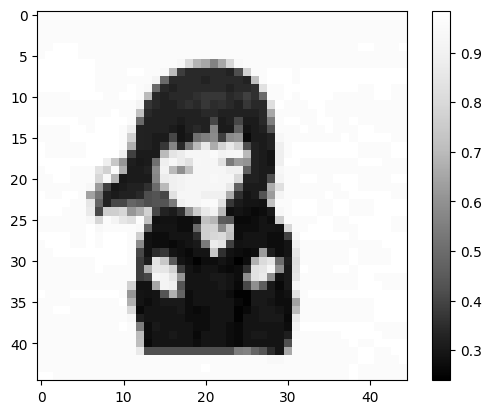

In [2]:
import matplotlib.pyplot as plt

train = get_cycled_data(5, is_rgb=False)[:, :, :, 0]
print(f'Train shape: {train.shape}')
test = get_cycled_data(1, is_rgb=False)[:, :, :, 0]
print(f'Test shape: {test.shape}')


plt.imshow(train[3], cmap='Greys_r')
plt.colorbar()
plt.show()

### Preparation datasets with moving window depend on prehistory and forecast horizon

In [3]:
from torchcnnbuilder.preprocess.time_series import multi_output_tensor, single_output_tensor

train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=20,
                                    forecast_len=10)
test_dataset = single_output_tensor(data=test, 
                                   forecast_len=10)

### Simple model (with 5 layers of convolutions and 5 layers of transpose convolutions) initialization - 20 frames as prehistory, 10 frames as forecast horizon.

In [4]:
from torch import nn
from torchcnnbuilder.models import ForecasterBase

model = ForecasterBase(input_size=[45, 45],
                       in_time_points=20,
                       out_time_points=10,
                       n_layers=5,
                       finish_activation_function=nn.ReLU(inplace=True))
device='cuda'
model=model.to(device)

### Train parameters set 

In [5]:
from torch import optim
from torch.utils.data import DataLoader

epochs = 100000
batch_size = 500

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
losses = []
epochs_list = []

### Training the model with progress save 

In [10]:
from tqdm.notebook import tqdm
import time
import os

# create folder for predicted images save
root = os.path.abspath("")
opt_hist_path = f'{root}/anime_opt_hist_images'
if not os.path.exists(opt_hist_path):
    os.makedirs(opt_hist_path)

start = time.time()
for epoch in tqdm(range(epochs)):
    loss = 0
    
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)    
        train_loss = criterion(outputs, test_features)        
        train_loss.backward()
        optimizer.step()        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)    
    losses.append(loss)
    epochs_list.append(epoch)
    
    # here we save optimization history as predicted images to visualize convergence process
    if epoch % 10000 == 0 or epoch == 5 or epoch==50 or epoch==300 or epoch == 1000 or epoch == 5000:
        for X, y in dataloader:
            X = X.to(device)
            prediction = model(X)
            prediction = prediction.detach().cpu().numpy()[0]
            real = y.numpy()[0]
    
            fig, (axs) = plt.subplots(2, 10, figsize=(10, 3))
            for i in range(10):
                axs[1, i].imshow(prediction[i], cmap='Greys_r', vmax=1, vmin=0)
                axs[1, i].set_title(F'Frame {i}')
                axs[0, i].imshow(real[i], cmap='Greys_r', vmax=1, vmin=0)
                axs[0, i].set_title(F'Frame {i}')
                axs[0, i].set_xticks([])
                axs[1, i].set_xticks([])
                axs[0, i].set_yticks([])
                axs[1, i].set_yticks([])
            plt.suptitle(f'Epoch={epoch}, loss={round(loss, 3)}')
            plt.tight_layout()
            plt.savefig(f'{opt_hist_path}/test_images_{epoch}.png')
            plt.close()

end = time.time()
print(f'time spent: {end-start}')

  0%|          | 0/100000 [00:00<?, ?it/s]

time spent: 406.92840790748596


Now in folder ***anime_opt_hist_images*** we have visualization of convergence process.  Saved png processed to gif: 

![SegmentLocal](tools/media/anime_convergence.gif "segment")

### Lets visualize convergence plot

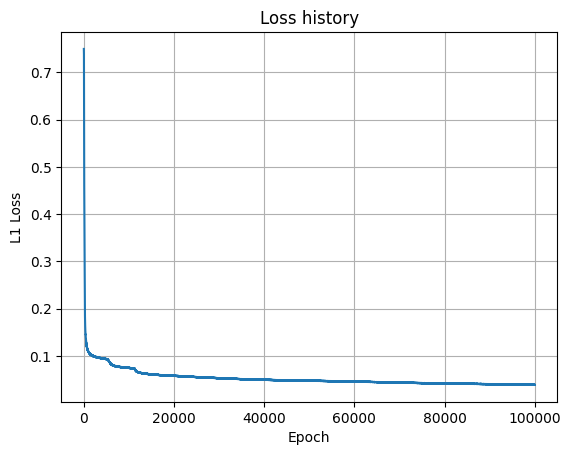

In [12]:
plt.plot(epochs_list, losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Loss history')
plt.show()

#### Conclusion

In [14]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters of the model: {params}')

Total trainable parameters of the model: 72990


In this case media data can be determined as synthetic time series with periodic component. As we can see from convergence plot and prediction visualizations during training, such simple model (less than 100k parameters) has ability to correctly approximate complex synthetic data.   